# IMDB EDA and Clustering

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("octopusteam/imdb-top-1000-movies")

print("Path to dataset files:", path)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /root/.cache/kagglehub/datasets/octopusteam/imdb-top-1000-movies/versions/19


## Import dependencies

In [2]:
# Import libraries
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")


## Load dataset

In [3]:
df = pd.read_csv(path + "/data.csv")
df.head()

,id,title,genres,averageRating,numVotes,releaseYear
0,tt0111161,The Shawshank Redemption,Drama,9.3,2951083,1994
1,tt0068646,The Godfather,"Crime, Drama",9.2,2057179,1972
2,tt0252487,The Chaos Class,Comedy,9.2,43570,1975
3,tt0259534,Ramayana: The Legend of Prince Rama,"Action, Adventure, Animation",9.2,15407,1993
4,tt16747572,The Silence of Swastika,"Documentary, History",9.2,10567,2021


## Data Normalization

Let's check the variable genres...

In [4]:
df.genres.unique()

array(['Drama', 'Crime, Drama', 'Comedy', 'Action, Adventure, Animation',
       'Documentary, History', 'Action, Crime, Drama',
       'Action, Adventure, Drama', 'Biography, Drama, History',
       'Action, Drama, Romance', 'Crime, Mystery, Thriller',
       'Biography, Crime, Documentary', 'Action, Adventure, Biography',
       'Action, Adventure, Sci-Fi', 'Drama, Romance',
       'Adventure, Drama, Western', 'Biography, Drama',
       'Action, Animation, Fantasy', 'Comedy, Drama', 'Drama, Family',
       'Adventure, Drama', 'Drama, Musical, Romance',
       'Adventure, Drama, Sci-Fi', 'Action, Sci-Fi',
       'Action, Adventure, Fantasy', 'Biography, Crime, Drama',
       'Crime, Drama, Mystery', 'Adventure, Comedy, Drama',
       'Documentary, Music', 'Action, Crime, Thriller',
       'Comedy, Horror, Mystery', 'Biography, Drama, Music',
       'Comedy, Drama, Family', 'Documentary, History, War',
       'Crime, Drama, Thriller', 'Drama, War', 'Crime, Drama, Fantasy',
       'Adve

As we can see, we have a lot of genres... But what if we split them?

In [5]:
# Split the genres by comma and explode the dataframe
df_movies = df.assign(genres=df['genres'].str.split(', ')).explode('genres')

In [6]:
df_movies.genres.unique()

array(['Drama', 'Crime', 'Comedy', 'Action', 'Adventure', 'Animation',
       'Documentary', 'History', 'Biography', 'Romance', 'Mystery',
       'Thriller', 'Sci-Fi', 'Western', 'Fantasy', 'Family', 'Musical',
       'Music', 'Horror', 'War', 'Sport', 'Film-Noir', 'News'],
      dtype=object)

Ok, now we have a list of genres we can work on...

# EDA

## Total number of Votes by Genre

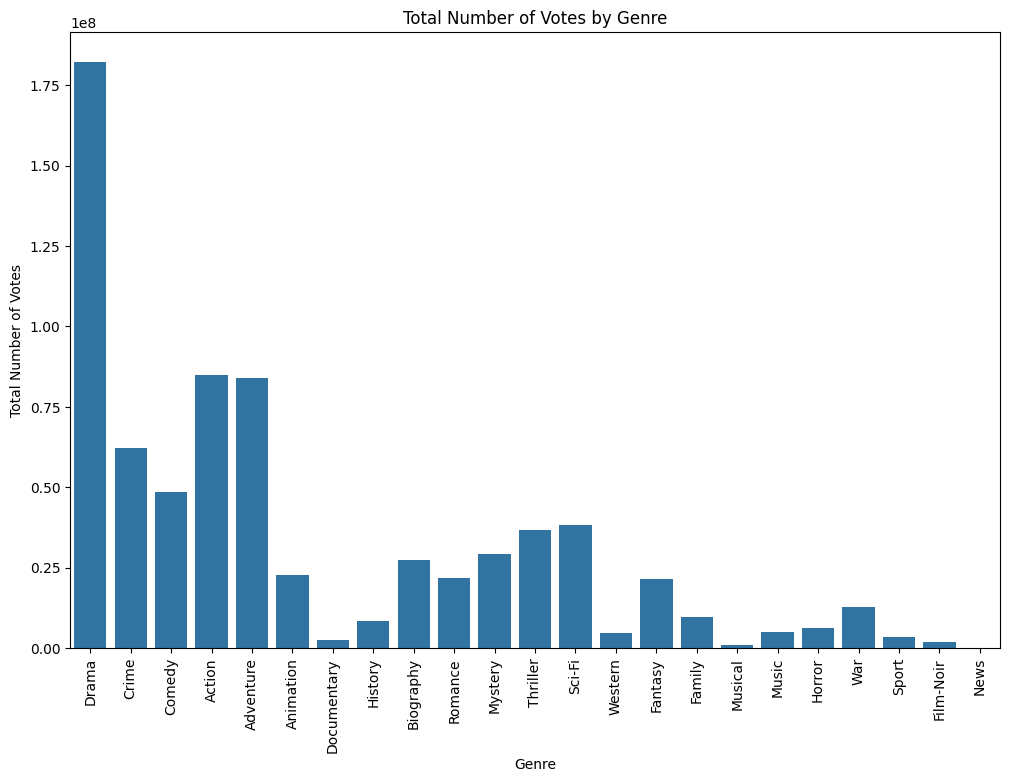

In [7]:
plt.figure(figsize=(12, 8))
sns.barplot(x='genres', y='numVotes', data=df_movies, estimator=sum, errorbar=None)
plt.xticks(rotation=90)
plt.title('Total Number of Votes by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Number of Votes')
plt.show()

Drama movies are for far the ones that are most voted... This might mean that they are movies that generate more sentiment on people.

## Mean Average Rating by Genre

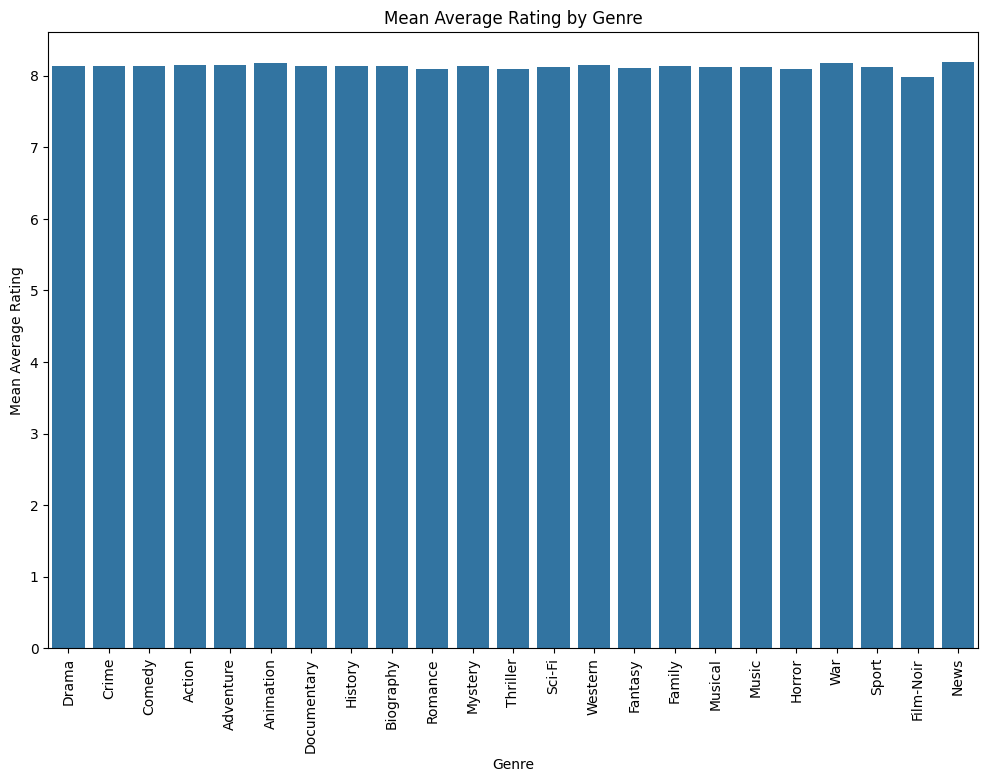

In [8]:
plt.figure(figsize=(12, 8))
sns.barplot(x='genres', y='averageRating', data=df_movies, estimator=np.mean, errorbar=None)
plt.xticks(rotation=90)
plt.title('Mean Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Mean Average Rating')
plt.show()

The dataset has the 1000 most voted movies, it doesn't surprise that most of them have outstanding average ratings...

## Mean Average Rating by Year

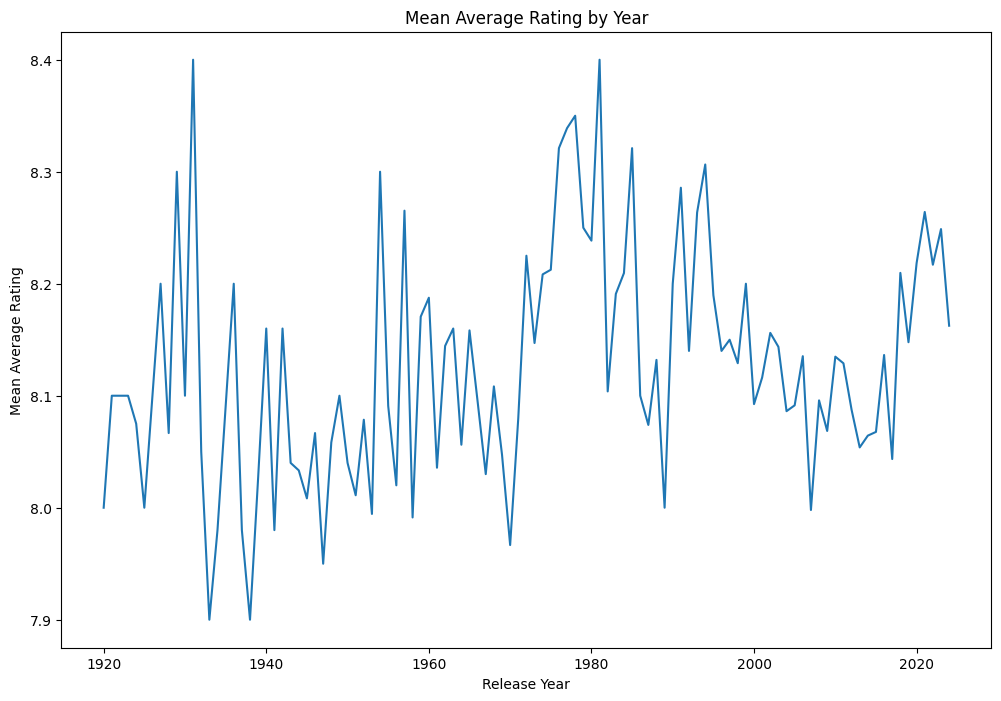

In [9]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='releaseYear', y='averageRating', data=df_movies, estimator=np.mean, errorbar=None)
plt.title('Mean Average Rating by Year')
plt.xlabel('Release Year')
plt.ylabel('Mean Average Rating')
plt.show()

This graphic confirms the previous observation: none of the movies have mean ratings below 7.9. Notably, the highest average ratings are clustered around the years 1930, 1955, and the 1980s to 1990s. Additionally, the film industry appears to experience cyclical periods of producing higher and lower quality movies.

## Total Number of Votes by Year

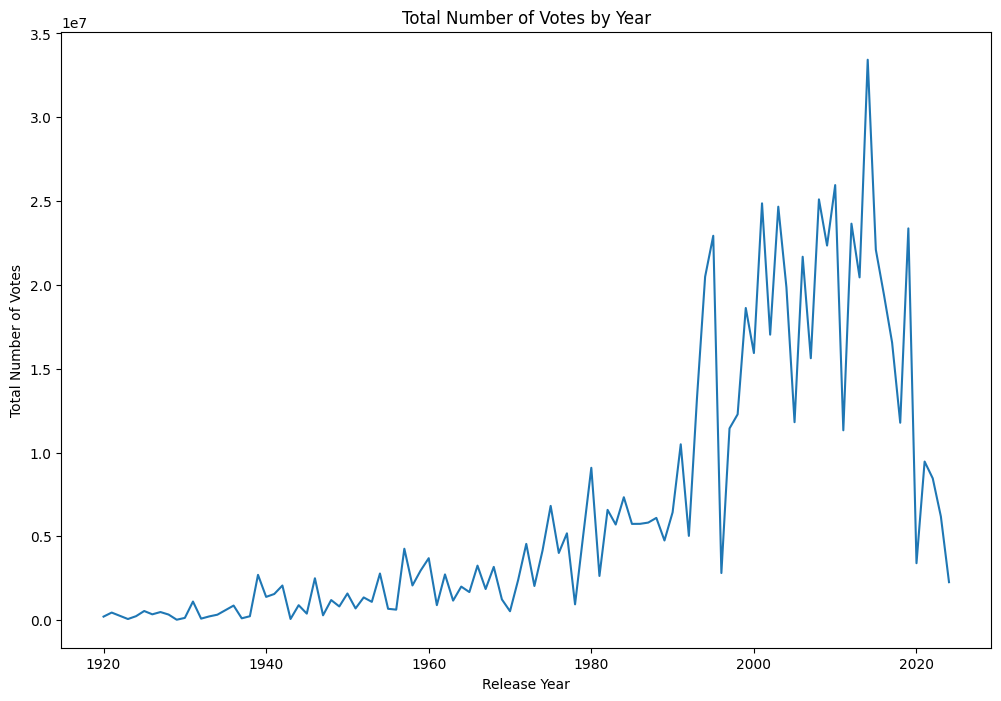

In [10]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='releaseYear', y='numVotes', data=df_movies, estimator=sum, ci=None)
plt.title('Total Number of Votes by Year')
plt.xlabel('Release Year')
plt.ylabel('Total Number of Votes')
plt.show()

In this plot, we observe that movies released between the 1990s and 2020 have significantly more reviews compared to other periods. There is a noticeable decline in reviews post-2020, which coincides with the COVID-19 pandemic. During this time, the film industry produced fewer movies, and streaming platforms became more dominant.

# Clustering

## Data preparation

First we will encode the genres to use them in the model

In [11]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the genres column
df_movies['genres_encoded'] = label_encoder.fit_transform(df_movies['genres'])

# Verify the changes
df_movies.head()

,id,title,genres,averageRating,numVotes,releaseYear,genres_encoded
0,tt0111161,The Shawshank Redemption,Drama,9.3,2951083,1994,7
1,tt0068646,The Godfather,Crime,9.2,2057179,1972,5
1,tt0068646,The Godfather,Drama,9.2,2057179,1972,7
2,tt0252487,The Chaos Class,Comedy,9.2,43570,1975,4
3,tt0259534,Ramayana: The Legend of Prince Rama,Action,9.2,15407,1993,0


Now we will select the columns that we will use... Actually what I do is to select the columns I won't be using in the model...

In [12]:
# Select the data to cluster, excluding specified columns
data_to_cluster = df_movies.loc[:, ~df_movies.columns.isin(['id', 'title', 'votes_per_rating', 'genres'])]

# Rearrange columns
data_to_cluster = data_to_cluster[['genres_encoded', 'averageRating', 'releaseYear', 'numVotes']]

data_to_cluster.head()

,genres_encoded,averageRating,releaseYear,numVotes
0,7,9.3,1994,2951083
1,5,9.2,1972,2057179
1,7,9.2,1972,2057179
2,4,9.2,1975,43570
3,0,9.2,1993,15407


Now we will scale the columns...

In [13]:
# Initialize the MinMaxScaler
data_to_cluster_scaler = MinMaxScaler()
data_to_cluster_scaled = data_to_cluster_scaler.fit_transform(data_to_cluster)

# Verify the changes
print(data_to_cluster_scaled[:3])

[[0.31818182 1.         0.71153846 1.        ]
 [0.22727273 0.93333333 0.5        0.69605037]
 [0.31818182 0.93333333 0.5        0.69605037]]


## Creating the Model
The model will be a simple KMeans model with 100 clusters..

In [14]:

# Fit the KMeans model with the weighted data
kmeans=KMeans(n_clusters = 50, init = 'k-means++', max_iter=3000, random_state=42)
kmeans.fit(data_to_cluster_scaled)


KMeans(max_iter=3000, n_clusters=50, random_state=42)

### Evaluating feature importance
We will see what variables the model take more into account and what it use less to create the clusters...

In [15]:
# Fit PCA to the data
pca = PCA(n_components=data_to_cluster_scaled.shape[1])
pca.fit(data_to_cluster_scaled)

# Get the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame to display the importance of each feature
feature_importance = pd.DataFrame({
    'Feature': data_to_cluster.columns,
    'Explained Variance': explained_variance
})

# Sort by explained variance
feature_importance = feature_importance.sort_values(by='Explained Variance', ascending=False)

feature_importance

,Feature,Explained Variance
0,genres_encoded,0.432286
1,averageRating,0.306319
2,releaseYear,0.170627
3,numVotes,0.090769


### Adding the cluster to the original df

In [16]:
df_movies['cluster'] = kmeans.labels_
df_movies.head()

,id,title,genres,averageRating,numVotes,releaseYear,genres_encoded,cluster
0,tt0111161,The Shawshank Redemption,Drama,9.3,2951083,1994,7,20
1,tt0068646,The Godfather,Crime,9.2,2057179,1972,5,29
1,tt0068646,The Godfather,Drama,9.2,2057179,1972,7,29
2,tt0252487,The Chaos Class,Comedy,9.2,43570,1975,4,49
3,tt0259534,Ramayana: The Legend of Prince Rama,Action,9.2,15407,1993,0,49


### Plotting the model clusters
We will prepare the data for visualization by applying PCA to reduce the dimensionality of the dataset to two components. <br>
This will enable us to plot the clusters in a 2D space, making it easier to interpret the clustering results and make a plot of the model.

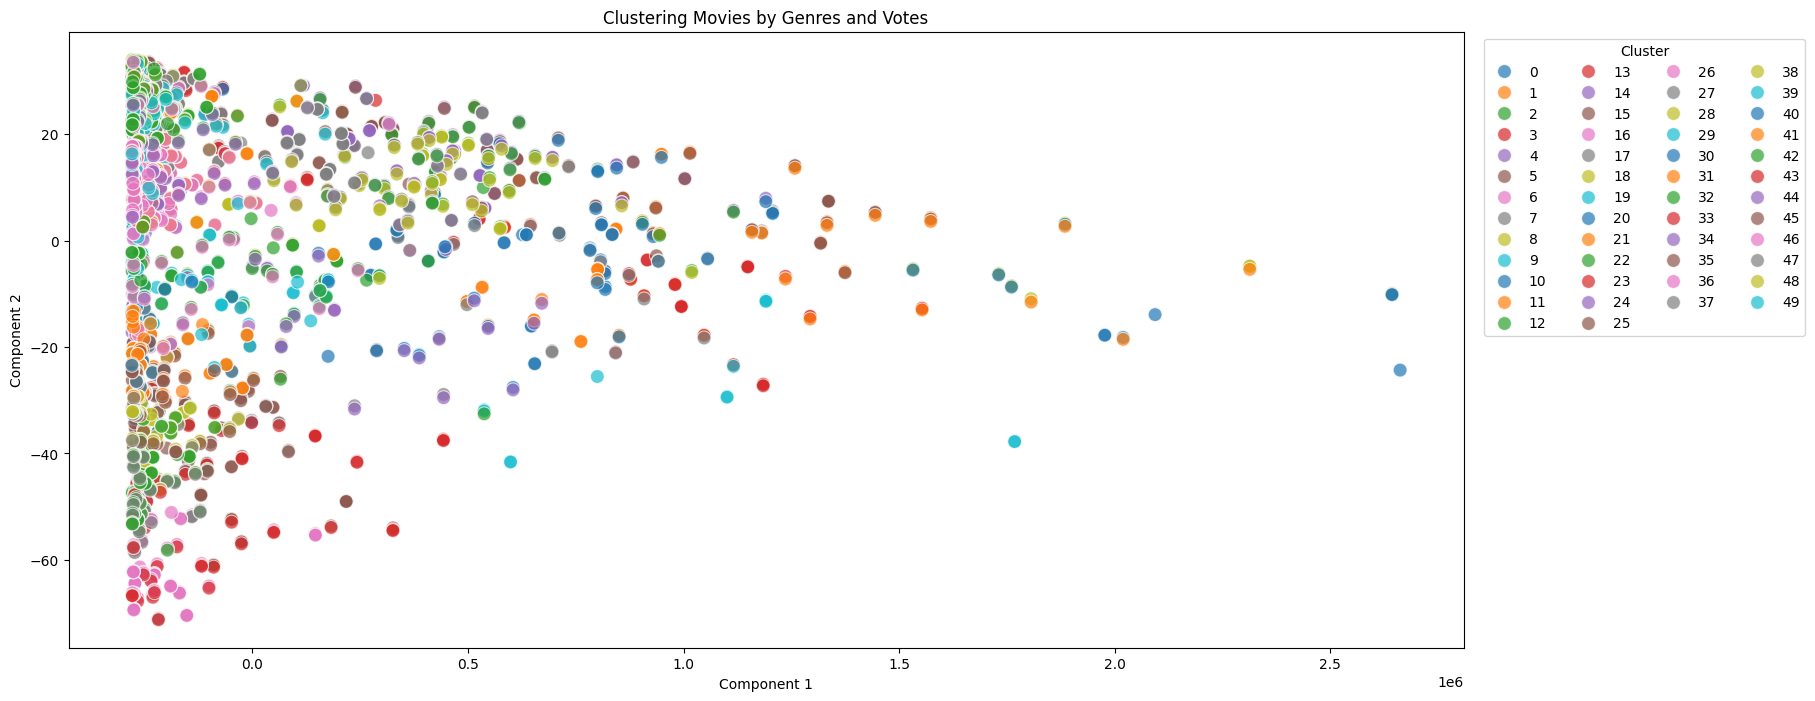

In [17]:
# Making the logic to plot a graph 
pca = PCA(2)
pca_res = pca.fit_transform(data_to_cluster)
data_to_cluster['X'] = pca_res[:,0]
data_to_cluster['Y'] = pca_res[:,1]

df_movies['X'] = data_to_cluster['X']
df_movies['Y'] = data_to_cluster['Y']

# Plotting the clusters using seaborn
plt.figure(figsize=(18, 8))
sns.scatterplot(data=df_movies, x='X', y='Y', hue='cluster', palette='tab10', s=100, alpha=0.7)
plt.title('Clustering Movies by Genres and Votes')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.01, 1), loc='upper left', ncol=4)
plt.show()

### Model prediction
We will see what movies the model group together by using one movie as example

In [18]:
title = 'The Godfather'

print(f'If you like {title}, you may also like:')
cluster = df_movies[df_movies['title'] == title]['cluster'].values[0]
recommended_movies = df_movies[(df_movies['cluster'] == cluster) & (df_movies['title'] != title)]
print(recommended_movies['title'].unique())


If you like The Godfather, you may also like:
["Schindler's List" 'The Godfather Part II' '12 Angry Men'
 'The Good, the Bad and the Ugly'
 'Star Wars: Episode V - The Empire Strikes Back'
 "One Flew Over the Cuckoo's Nest"]


# Conclusion

This notebook provided an in-depth exploration of the IMDB Top 1000 Movies dataset.<br>
We have done an exploratory data analysis (EDA). <br>
Then, we prepared the data for clustering by encoding categorical variables and scaling numerical ones.<br> 
Using the KMeans algorithm, we clustered the movies into 100 groups. <br>
The importance of each feature in the clustering process was evaluated using PCA, and the clusters were visualized.<br>
Finally, we demonstrated how to use the clustering model to recommend movies based on a given title. This approach can help users discover movies with similar characteristics, enhancing their viewing experience.